# XGBoost

In [1]:
from Functions import get_result, plot_precision_recall_vs_threshold, plot_roc_curve, save_metrics_to_json
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [3]:
# The scores we want to look at
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

#### Hyperparameter Tuning

In [4]:
# We'll need the count of each class for a hyperparameter
risk_count = Y_train.value_counts()

In [5]:
param_grid = {
    'n_estimators': [100, 250, 500, 1000],      # Number of trees
    'max_depth': [5, 10, 25, 75],               # Maximum depth of a tree
    'learning_rate': [0.1, 0.5, 1, 2.5],        # Step size shrinkage used in update to prevent overfitting
    'objective': ['binary:logistic'],           # The learning task and the corresponding learning objective
    'eval_metric': ['aucpr'],                   # Evaluation metrics for validation data
    'scale_pos_weight': [1, 100, 250, 500,      # Control the balance of positive and negative weights
                         risk_count[0]/risk_count[1]] # Typical value to consider
}

In [6]:
# Initialize the RandomForestClassifier
xgb = XGBClassifier()

# Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=1, random_state=42, n_jobs=-1,
                               scoring=scoring, refit='f1')


In [7]:
xgb_random.fit(X_train, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'scale_pos_weight': [1, 100, 250, 500,
                                                             709.7916666666666]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, response_method='predict', zero_division=0),
                            'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                            'recall': make_scorer(recall_score, response_method='predict', zero_division=0)},
                   verbose=1)

In [8]:
# Look at the results of the hyperparameter tuning
xgb_random_result_df = pd.DataFrame(xgb_random.cv_results_['params'])
xgb_random_result_df['Mean_Accuracy'] = xgb_random.cv_results_['mean_test_accuracy']
xgb_random_result_df['Mean_Recall'] = xgb_random.cv_results_['mean_test_recall']
xgb_random_result_df['Mean_Precision'] = xgb_random.cv_results_['mean_test_precision']
xgb_random_result_df['Mean_f1'] = xgb_random.cv_results_['mean_test_f1']
xgb_random_result_df['Rank_Recall'] = xgb_random.cv_results_['rank_test_recall']
xgb_random_result_df['Rank_Precision'] = xgb_random.cv_results_['rank_test_precision']
xgb_random_result_df['Rank_F1'] = xgb_random.cv_results_['rank_test_f1']
xgb_random_result_df.sort_values('Rank_F1')

,scale_pos_weight,objective,n_estimators,max_depth,learning_rate,eval_metric,Mean_Accuracy,Mean_Recall,Mean_Precision,Mean_f1,Rank_Recall,Rank_Precision,Rank_F1
47,709.791667,binary:logistic,500,10,1.0,aucpr,0.997201,0.390625,0.221309,0.282376,5,8,1
19,709.791667,binary:logistic,100,10,0.5,aucpr,0.997186,0.390625,0.220252,0.281532,5,12,2
41,500.000000,binary:logistic,500,10,1.0,aucpr,0.997208,0.388021,0.221015,0.281494,7,9,3
22,500.000000,binary:logistic,1000,10,1.0,aucpr,0.997208,0.388021,0.221015,0.281494,7,9,3
29,500.000000,binary:logistic,100,10,1.0,aucpr,0.997205,0.388021,0.220790,0.281334,7,11,5
0,250.000000,binary:logistic,250,5,1.0,aucpr,0.997142,0.393229,0.217004,0.279533,4,17,6
15,709.791667,binary:logistic,1000,10,0.5,aucpr,0.997197,0.385417,0.219464,0.279521,13,13,7
49,250.000000,binary:logistic,1000,5,1.0,aucpr,0.997179,0.388021,0.218534,0.279444,7,15,8
27,500.000000,binary:logistic,500,10,0.1,aucpr,0.997194,0.385417,0.218852,0.279047,13,14,9
14,250.000000,binary:logistic,500,5,1.0,aucpr,0.997172,0.388021,0.218005,0.278957,7,16,10


In [9]:
# Evaluate the Best Model
print(f"Best Parameters: {xgb_random.best_params_}")
best_xgb = xgb_random.best_estimator_

Best Parameters: {'scale_pos_weight': 709.7916666666666, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 1, 'eval_metric': 'aucpr'}


In [10]:
# Save the best model
best_xgb.save_model('Saved models/xgb_best_model.json')

In [11]:
# Predict on the test set
test_predictions = best_xgb.predict(X_test)

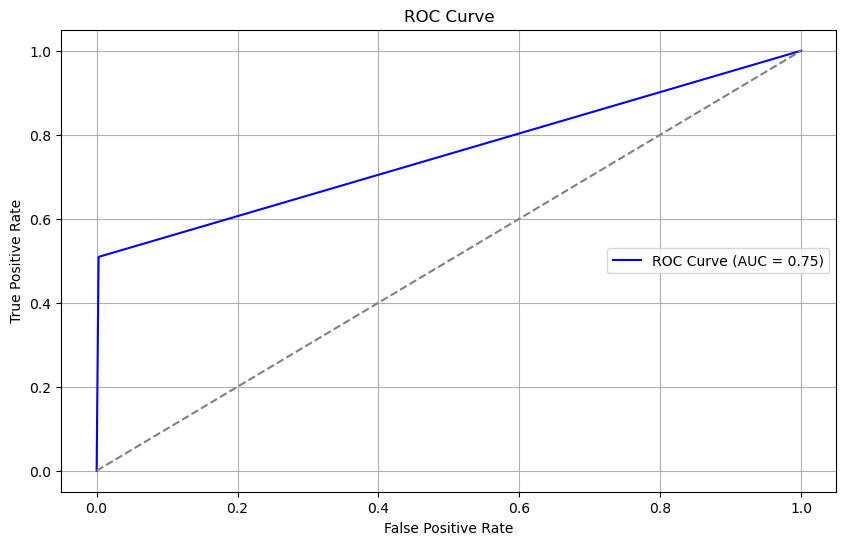

In [12]:
plot_roc_curve(Y_test, test_predictions)

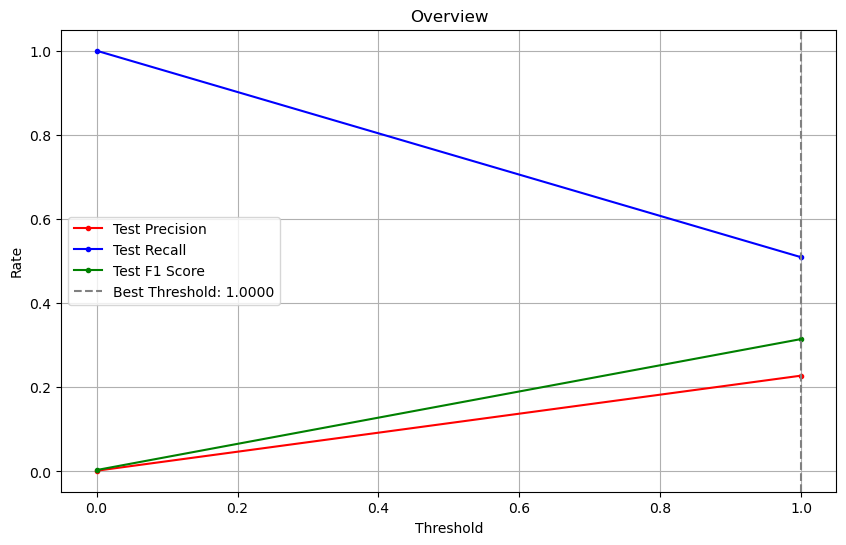

In [13]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

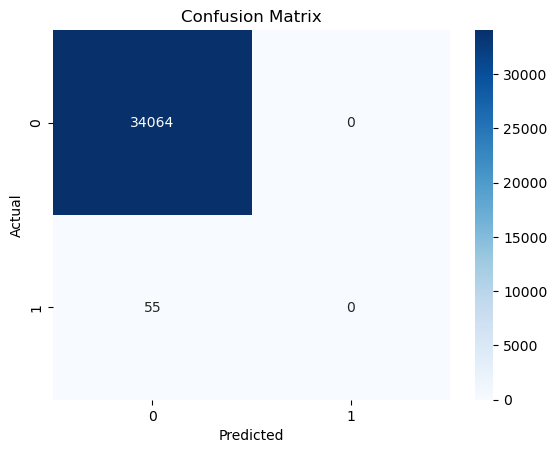

Recall       = 0.0
Precision    = 0.0
F1           = 0.0


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
recall_1, precision_1, f1_1 = get_result(Y_test, test_predictions, best_threshold)

Lets again merge the training and validation set and predict on the test set to see if the model can perform better with more training data.



In [15]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
xgb = XGBClassifier(
    n_estimators = xgb_random.best_params_['n_estimators'],
    max_depth = xgb_random.best_params_['max_depth'],
    learning_rate = xgb_random.best_params_['learning_rate'],
    objective = xgb_random.best_params_['objective'],
    eval_metric = xgb_random.best_params_['eval_metric'],
    scale_pos_weight = xgb_random.best_params_['scale_pos_weight']
)

In [16]:
# Train the model
xgb.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
test_predictions = xgb.predict(X_test)

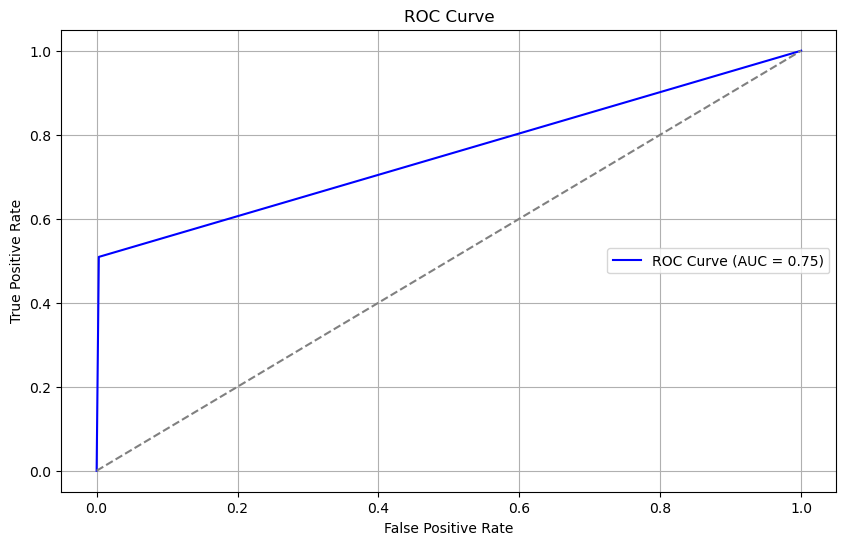

In [18]:
plot_roc_curve(Y_test, test_predictions)

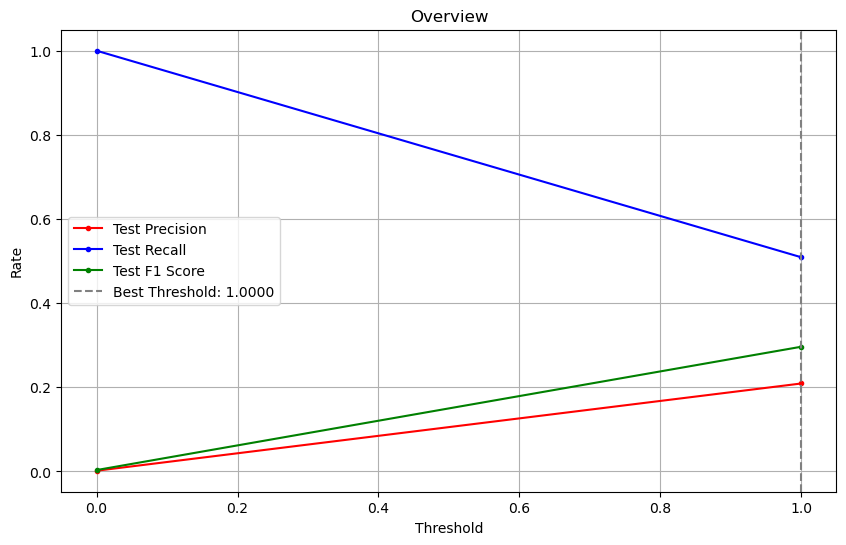

In [19]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

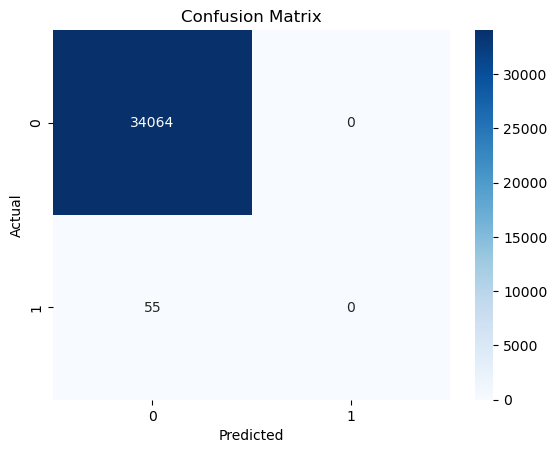

Recall       = 0.0
Precision    = 0.0
F1           = 0.0


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
recall_2, precision_2, f1_2 = get_result(Y_test, test_predictions, best_threshold)

In [21]:
if f1_2 > f1_1:
    xgb.save_model('Saved models/xgb_best_model.json')
    save_metrics_to_json('XGBoost', recall_2, precision_2, f1_2)
    print('By training our model on more data, we achived a higher performance')
else:
    save_metrics_to_json('XGBoost', recall_1, precision_1, f1_1)
    print('The first model we found, through hyperparameter tuning, is still our best model.')
    print('It had the following scores:')
    print('Recall       =', round(recall_1, 2))
    print('Precision    =', round(precision_1, 2))
    print('F1           =', round(f1_1, 2))

The first model we found, through hyperparameter tuning, is still our best model.
It had the following scores:
Recall       = 0.0
Precision    = 0.0
F1           = 0.0
